In [7]:
from dependencies.NN import *
from dependencies.LTL import *
from dependencies.Utility_funcs import *
from dependencies.maps import grid_world
from dependencies.RL_LTL import RL_LTL

from dependencies.csrl.mdp import GridMDP
from dependencies.csrl.oa import OmegaAutomaton
from dependencies.csrl import ControlSynthesis
import numpy as np

from matplotlib import pyplot as plt

[[('d',) () () () () () () () () ()]
 [('d',) () ('b',) () () () () () () ()]
 [() () () () () () () () ('d',) ()]
 [() () () () ('d',) () () () ('d',) ()]
 [() () () ('c',) () () () () () ()]
 [() () () () () () () () () ('d',)]
 [('d',) () () () () () () () () ()]
 [() () () () () () () () () ()]
 [() ('d',) () () () () () () ('a',) ('d',)]
 [() () () () () () () () () ('d',)]]
Number of Omega-automaton states (including the trap state): 6


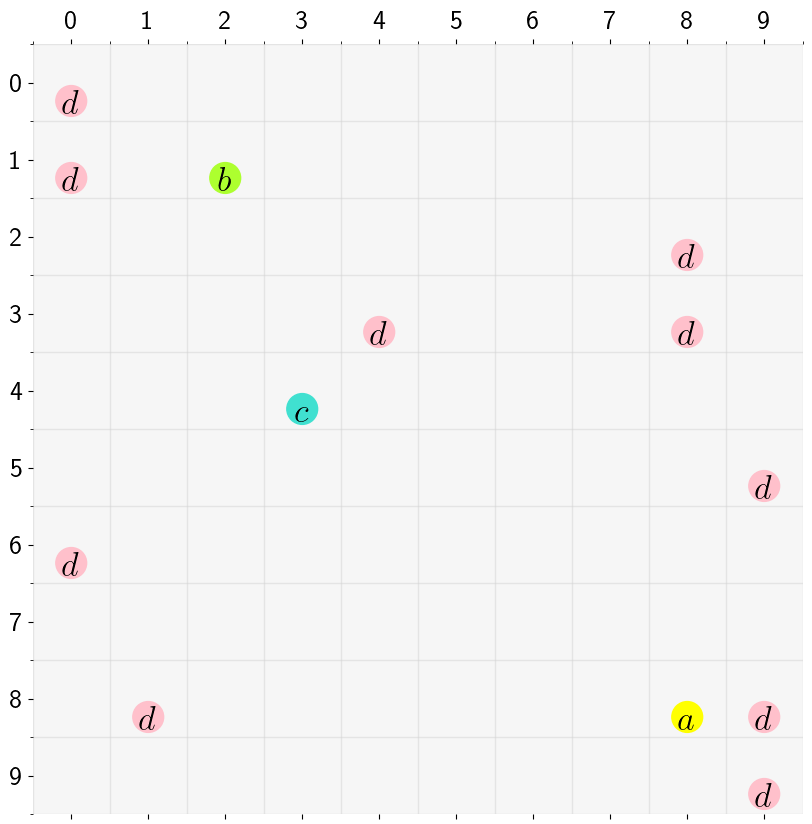

In [8]:
gw = grid_world(name='random', shape=(10,10))

Number of Omega-automaton states (including the trap state): 2


KeyError: ('i',)

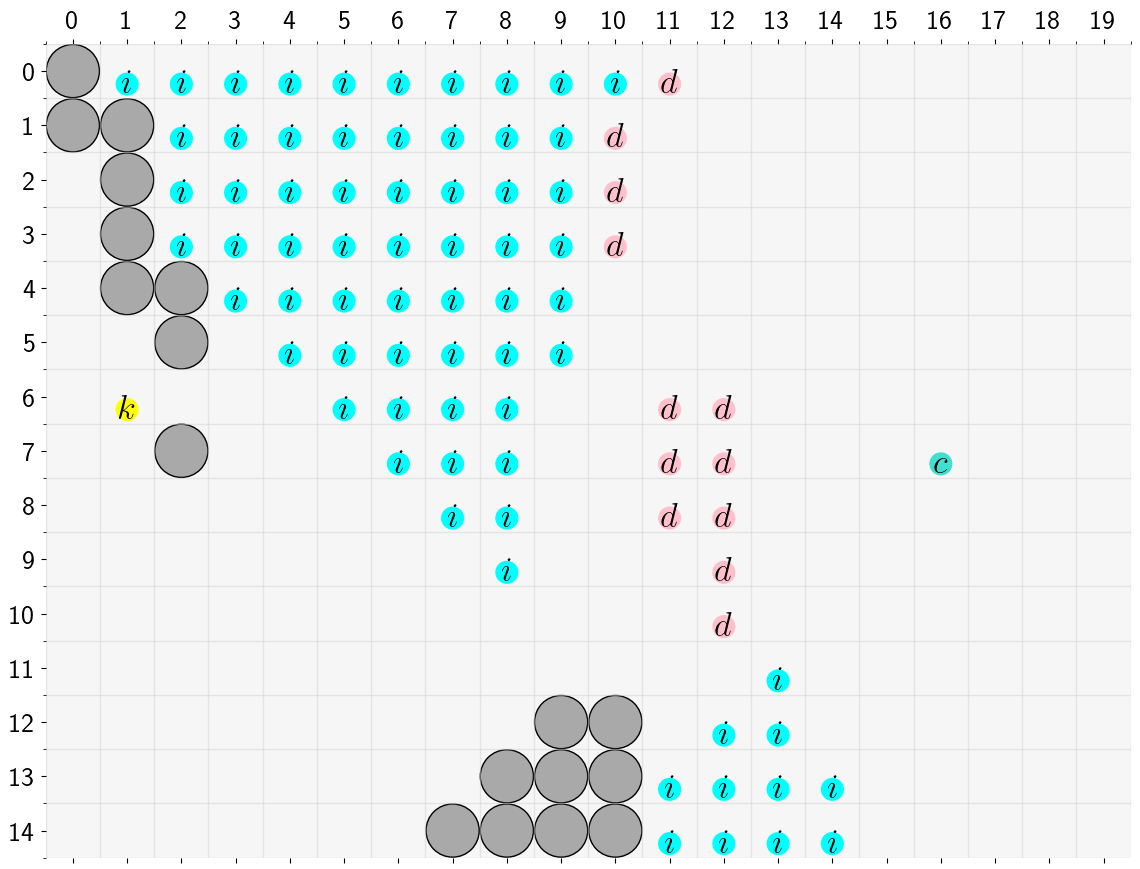

In [2]:
gw = grid_world('frozen_lake')
model = build_model(gw.ch_states[(0,0,0,0)].shape, gw.csrl.shape[-1])
# print(model.summary())
model.load_weights(f'outputs/models/New_p{gw.p}')
env = RL_LTL(gw, model)

In [3]:
# env.train(50)
env.get_policy(20, reset_tables=False)

[0. 0. 0. 0.]
0 ) MCTS conf: 0.19 , det: 1.0 | LTL [---]  LDBA [ 0.0 ] path: [96, 97, 77, 57, 56, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 3, 2, 22, 21, 20, 40, 60, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 109, 108, 128, 148, 147, 167, 147, 127, 128, 108, 109, 129, 130, 131]
[  10.   12. 2528.   10.]
1 ) MCTS conf: 0.35 , det: 1.0 | LTL [+++]  LDBA [ 0.0 ] path: [89, 109, 108, 128, 148, 147, 167, 147, 146, 126, 106, 86, 87, 88, 68, 69, 49, 50, 51, 52, 53, 54, 55, 54, 53, 52, 51, 31, 30, 50, 49, 48, 47, 27, 26, 25, 24, 24, 4]
[  10.   12. 2528.   10.]
2 ) MCTS conf: -0.5 , det: 1.0 | LTL [---]  LDBA [ 0.0 ] path: [64, 44, 43, 42, 41, 40, 60, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 109, 129, 128, 148, 147, 167, 166, 165, 164, 163, 162, 161, 141, 142, 122, 121, 101, 81, 61, 62, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]
[  10.   15. 3639.   10.]
3 ) MCTS conf: -0.47 , det: 1.0 | LTL [---]  LDBA [ 0.0 ] path: [65, 85, 86, 87, 88, 89, 109, 108, 128, 148, 147, 167, 166

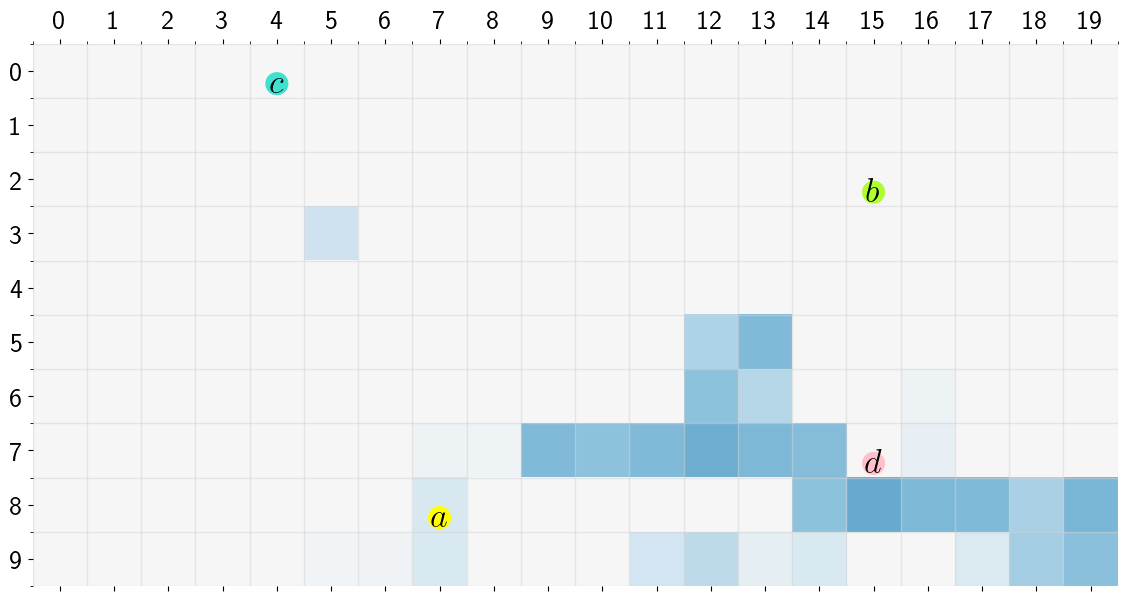

In [5]:
gw.mdp.plot(value=env.value[0,0])

In [10]:
env.evaluate(verbose=0, len=40, runs=100)

Running 100 simulations with 40 time-steps...
Test finished with:
	success rate: 20 / 100 = 0.2


In [17]:
model.save_weights(f'outputs/models/New_p{gw.p}')

In [5]:
N1 = np.load(f'outputs/Ours/New_p{gw.p}.npy')

In [4]:
policy2=np.argmax(env.N,axis=4)
value2=np.max(env.N,axis=4)
# np.save(f'outputs/Ours/New_p{env.p}', env.N)

In [29]:
episodes, rew = run_Q_test(gw.csrl, policy2, gw.LTL_formula, gw.predicates, start=None, T=50, runs=1000, verbose=0, reachability=True)

Running 1000 simulations with 50 time-steps...


TypeError: cannot unpack non-iterable NoneType object

In [25]:
rew.sum()

AttributeError: 'list' object has no attribute 'sum'

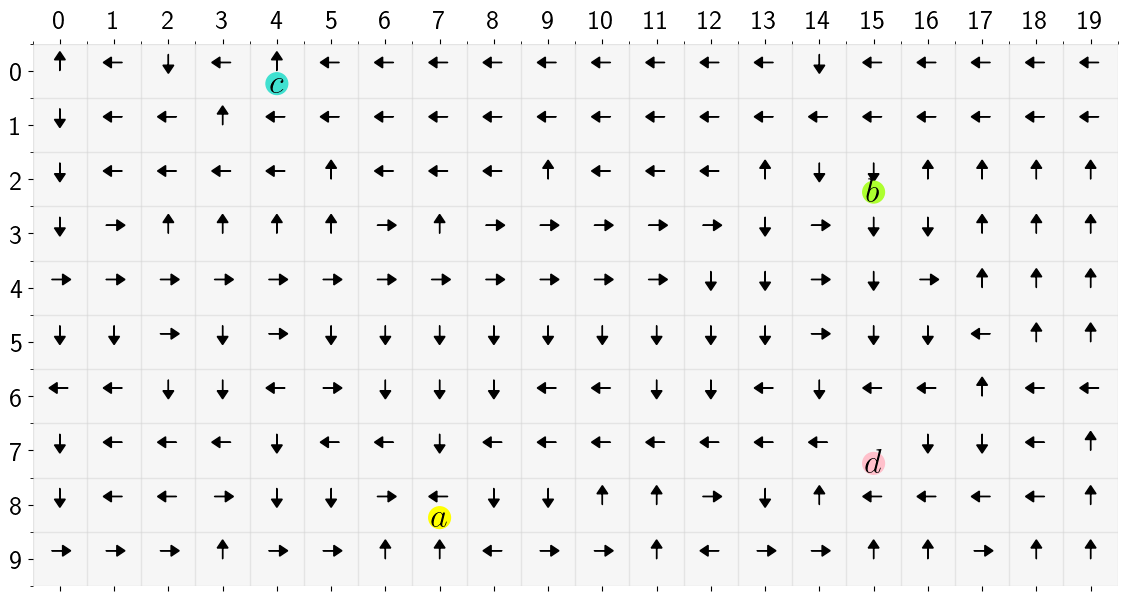

In [21]:
gw.mdp.plot(policy=policy2[0, 0])

In [13]:
csrl.mdp.label[3,0]

('c',)

In [28]:
(W[state])/N[state]

/tmp/ipykernel_13239/3964365869.py:1: RuntimeWarning: invalid value encountered in divide
  (W[state])/N[state]


array([-0.5      , -0.5      , -0.5      , -0.4983165,        nan,
              nan,        nan,        nan,        nan,        nan])

In [26]:
state = (0, 0, 4, 3)
print([round(i,2) for i in Q[state][:6]])
print([round(i,2) for i in W[state][:6]])
print([round(i,2) for i in N1[state][:8]])
csrl.transition_probs[(state)][2]

[-0.5, -0.5, -0.5, -0.5, 0.0, 0.0]
[-1.5, -16.5, -8.5, -444.0, 0.0, 0.0]
[3.0, 33.0, 17.0, 891.0, 0.0, 0.0, 0.0, 0.0]


([(0, 0, 3, 3), (0, 0, 4, 4)], [0.0, 1])

In [ ]:
# u, d, r, l

0.8170728068875467

In [9]:
Q =gw.csrl.q_learning(T=100,K=100000)
np.save(f'outputs/CSRL/New_p{gw.p}', Q)

In [10]:
policy1=np.argmax(Q,axis=4)
value1=np.max(Q,axis=4)

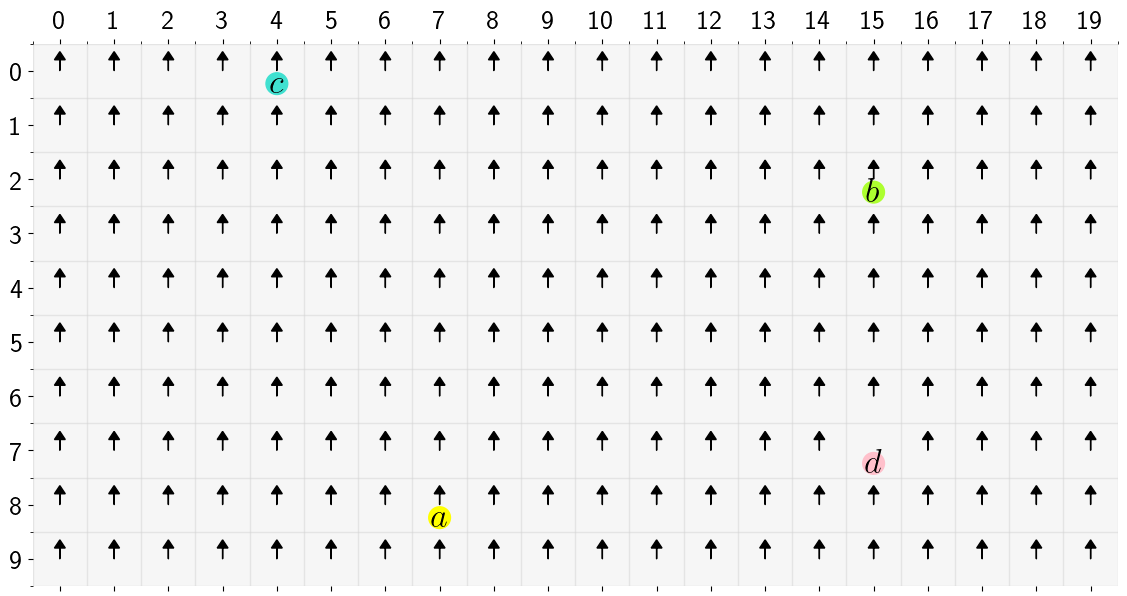

In [12]:
gw.mdp.plot(policy=policy1[0, 0])

In [13]:
episodes, rew = run_Q_test(gw.csrl, policy1, gw.LTL_formula, gw.predicates, start=None, T=50, runs=1000, verbose=0, reachability=True)

Running 1000 simulations with 50 time-steps...
Test finished with:
	success rate: 0 / 1000 = 0.0


In [ ]:
visited_states_train = []
visited_states_test = []
LTL_coef = 10

search_depth = 30
MCTS_samples = 100

num_training_epochs =  30
num_test_epochs = 10
training = True
epochs = 10
T = [25]
K = 1
batch_size = 32
steps_per_epoch = 4

success_rates = []
succes_std = []
win_hist = []
train_history = []

os.remove("Log_run.txt")
for i in T:
    # TRAIN ##############################
    train_wins = 0
    # num_training_epochs = int(200 - 1.9*i)
    # model = build_model(ch_states[(0,0,0,0)].shape, csrl.shape[-1])
    N, W, Q, P, visited_train = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()
    for epoch in range(num_training_epochs):
        t1 = time.time()
        print(Q[(0,0,0,0)][:4], len(visited_train))
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy = MC_learning(csrl, model, LTL_formula,
                predicates, csrl.reward, ch_states, N = N, W = W, Q = Q, P = P, C=0.5, tow=1, n_samples=MCTS_samples, visited=visited_train,
                start=(0,0), search_depth=search_depth, verbose=0, T=i, K=K, run_num=epoch, ltl_f_rew=False)
        
        # print('N',N[(0,0,4,1)][:5])
        visited_states_train += state_history
        t2 = time.time()
        # print(t2-t1, " run episode")

        # win = check_LTL(LTL_formula, trajectory, predicates)[0]
        if reward_history[-1]>0: train_wins+=1

        if training and len(action_history)>0:
            if epoch==0:
                x_train = np.array(channeled_states)[:-1]
                y1_train = np.array(better_policy)
                y2_train = np.array(reward_history) + LTL_coef*reward_history[-1]
                # y2_train = np.array(reward_history)
                y2_train = y2_train[:-1]
            else:
                x_train = np.concatenate((x_train, np.array(channeled_states)[:-1]),0)
                y1_train = np.concatenate((y1_train, np.array(better_policy)),0)
                y2_train_curr = np.array(reward_history) + LTL_coef*reward_history[-1]
                # y2_train_curr = np.array(reward_history)
                y2_train = np.concatenate((y2_train, y2_train_curr[:-1]),0)
            t3= time.time()
            # print(t3-t2, " build database")
            tr_hist = model.fit(x_train, [y1_train, y2_train], epochs=epochs, batch_size=batch_size,
                                steps_per_epoch=steps_per_epoch if len(x_train)>steps_per_epoch*epochs*batch_size else None, verbose=0)
            train_history += tr_hist.history['loss']
        # win_hist.append(win)
        t4 = time.time()
        # print(t4-t3, "fit", len(x_train))
    print("Train wins:",train_wins,"/", num_training_epochs)

    # TEST ##############################
    test_wins = 0
    N, W, Q, P, visited_test = np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), np.zeros(csrl.shape), set()
    for epoch in range(num_test_epochs):
        
        state_history, channeled_states, trajectory, action_history, reward_history, better_policy = MC_learning(csrl, model, LTL_formula,
                predicates, csrl.reward, ch_states, N = N, W = W, Q = Q, P = P, C=1, tow=1, n_samples=MCTS_samples, visited=visited_test,
                start=(0,0), search_depth=search_depth, verbose=0, T=i, K=1, NN_value_active=True)

        # win = check_LTL(LTL_formula, trajectory, predicates)[0]
        win = reward_history[-1]
        if win: test_wins+=1
        win_hist.append(win)
        visited_states_test += state_history
        
    success_rates.append(100*test_wins/num_test_epochs)
    temp = np.zeros(num_test_epochs)
    temp[:test_wins]=1
    std = np.sqrt(num_test_epochs*np.var(temp))
    succes_std.append((success_rates[-1]-std, success_rates[-1]+std))
    ###############################################################
    print("Test wins:",test_wins,"/",num_test_epochs)
    # print("last reward:", reward_history[-1], "  | trajectory:", trajectory)
    # print("Actions:", action_history)

encode_visited_states_test = [i[1]*csrl.shape[-2]*csrl.shape[-3]+i[2]*csrl.shape[-2]+i[3] for i in visited_states_test]
encode_visited_states_train = [i[1]*csrl.shape[-2]*csrl.shape[-3]+i[2]*csrl.shape[-2]+i[3] for i in visited_states_train]

[0. 0. 0. 0.] 0
0 ) MCTS conf: -27.0 , det: 1.0 | 

c:\Users\pc-admin\OneDrive - University of Waterloo\MSc\research\Code\RL-LTL\ComputeCanada_scrips\Utility_funcs.py:300: RuntimeWarning: overflow encountered in power
  Pi = (N[root]**(1/tow)) / np.sum(N[root]**(1/tow))
c:\Users\pc-admin\OneDrive - University of Waterloo\MSc\research\Code\RL-LTL\ComputeCanada_scrips\Utility_funcs.py:300: RuntimeWarning: invalid value encountered in divide
  Pi = (N[root]**(1/tow)) / np.sum(N[root]**(1/tow))


Warning
Pi: [ 0.  0.  0. nan  0.  0.  0.  0.  0.  0.]
N[root]: [7.000e+00 1.000e+00 4.000e+00 1.239e+03 0.000e+00 0.000e+00 6.000e+00
 0.000e+00 0.000e+00 0.000e+00]
root: (0, 1, 2, 1)
depth: -11
trajectory [0, 1, 2, 3, 4, 9, 14, 19, 24, 23, 22, 23, 24, 19, 14, 13, 12] + 11


ValueError: probabilities contain NaN

exploration in training: 0.35
exploration in testing: 0.18


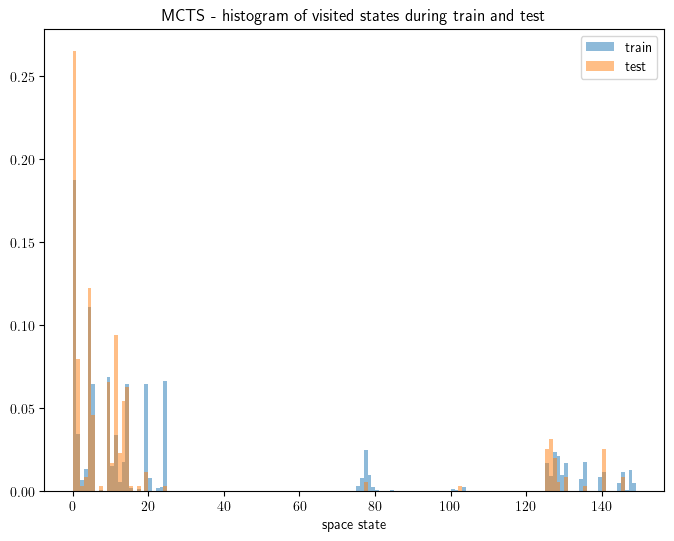

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(encode_visited_states_train, bins=range(total_number_of_states), density=True, alpha=0.5, label="train")
plt.title("MCTS - histogram of visited states during train and test")
plt.xlabel("space state")

plt.hist(encode_visited_states_test, bins=range(total_number_of_states), density=True, alpha=0.5, label="test")
plt.legend()

print("exploration in training:", round(np.unique(encode_visited_states_train).shape[0]/total_number_of_states, 2))
print("exploration in testing:", round(np.unique(encode_visited_states_test).shape[0]/total_number_of_states, 2))

ValueError: x and y must have same first dimension, but have shapes (1,) and (3,)

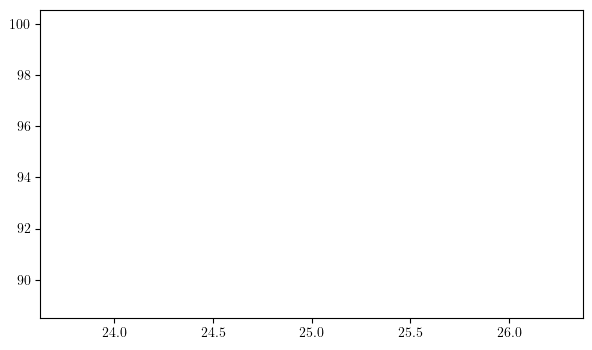

In [8]:
succes_std = np.array(succes_std)

plt.figure(figsize=(7,4))
plt.fill_between(T, succes_std[:,0], succes_std[:,1], alpha=0.3, label="MCTS area of 1 STD")

plt.plot(T, success_rates)
plt.xlabel("length of trajectory (T)")
plt.ylabel(f"succes rate (out of {num_test_epochs} runs)")
plt.title("MCTS performance results on the custom gridworld, P="+str(p))
success_rates

Text(0.5, 1.0, 'training loss')

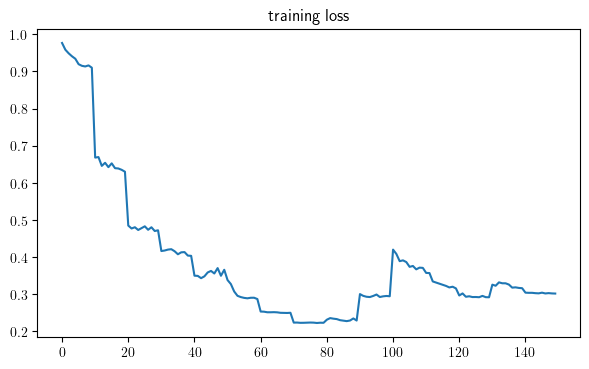

In [ ]:
interval = 400
plt.figure(figsize=(7,4))
plt.plot(train_history)
plt.title("training loss")
# plt.xticks(range(1,num_training_epochs*epochs,interval), range(0,num_training_epochs,interval//epochs));

In [5]:
Q, visited_states =csrl.q_learning(T=100,K=10000)
np.save(f'outputs/CSRL/SD_{p}', Q)

In [16]:
policy=np.argmax(Q,axis=4)
value=np.max(Q,axis=4)

In [17]:
rewards_mean = []
rewards_std = []
n_runs = 100

T = [26, 50, 75, 100, 150, 200, 300, 400]

for i in T:
    episodes, rew = run_Q_test(csrl, policy, LTL_formula, predicates, T=i, start=(0,0), runs=n_runs, verbose=0)
    rewards_mean.append(100*np.mean(rew))
    rewards_std.append((rewards_mean[-1]-np.sqrt(n_runs*np.var(rew)), rewards_mean[-1]+np.sqrt(n_runs*np.var(rew))))
rewards_std = np.array(rewards_std)

Running 100 simulations with 26 time-steps...
Test finished with:
	success rate: 0 / 100 = 0.0
Running 100 simulations with 50 time-steps...
Test finished with:
	success rate: 0 / 100 = 0.0
Running 100 simulations with 75 time-steps...
Test finished with:
	success rate: 0 / 100 = 0.0
Running 100 simulations with 100 time-steps...
Test finished with:
	success rate: 0 / 100 = 0.0
Running 100 simulations with 150 time-steps...
Test finished with:
	success rate: 0 / 100 = 0.0
Running 100 simulations with 200 time-steps...
Test finished with:
	success rate: 0 / 100 = 0.0
Running 100 simulations with 300 time-steps...
Test finished with:
	success rate: 0 / 100 = 0.0
Running 100 simulations with 400 time-steps...
Test finished with:
	success rate: 0 / 100 = 0.0


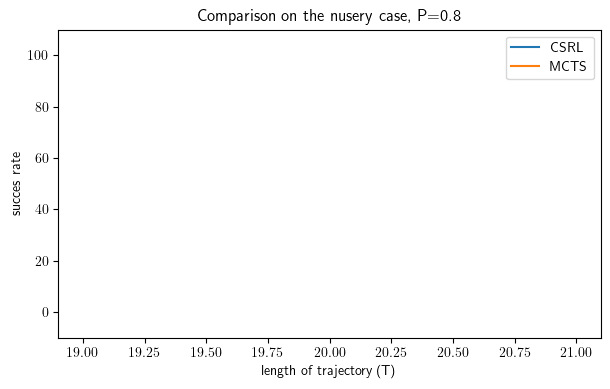

In [ ]:
plt.figure(figsize=(7,4))

plt.fill_between(T, rewards_std[:,0], rewards_std[:,1], alpha=0.3)
plt.plot(T, rewards_mean, label="CSRL")
plt.xlabel("length of trajectory (T)")
plt.ylabel("succes rate")
plt.title("Comparison on the sequentil delivery case, P="+str(p))
plt.ylim(-10, 110)

plt.fill_between(T, succes_std[:,0], succes_std[:,1], alpha=0.3)
plt.plot(T, success_rates, label="RL-LTL")
plt.legend()